In [885]:
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import Dense, Activation
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline

# Training phase

### Load Data

In [886]:
# load train.csv and training-label.csv
train_data: pd.DataFrame = pd.read_csv("data/train.csv", encoding="utf-8")
train_label: pd.DataFrame = pd.read_csv("data/train_label.csv", encoding="utf-8")

### Data Preprocessing

In [887]:
# drop created_time column
train_data.drop("created_time", axis=1, inplace=True)

In [888]:
# Count whether each mac_hash has passed through these 14 locations, and generate a training dataframe
row_buffer: dict = dict()
for _, value in enumerate(zip(train_data["mac_hash"].values.tolist(), train_data["sniffer_loc"].values.tolist())):
    if value[0] not in row_buffer.keys():
        row_buffer[value[0]] = [0 for _ in range(14)]
    row_buffer[value[0]][int(value[1]) - 1] = 1
train_set: pd.DataFrame = pd.DataFrame(row_buffer).transpose()
train_set.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
train_set["mac_hash"] = train_set.index
train_set.reset_index(inplace=True)
train_set.drop("index", axis=1, inplace=True)

In [889]:
# Add label column
train_set = train_set.merge(train_label)
train_set

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,mac_hash,label
0,0,1,1,1,1,1,1,0,1,1,1,1,0,1,10f6ad2e3fa3b3da8ceb3fbd95658681,4
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5272841b630d74290ec129c64dd6378b,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,8ab74d094708a27c9660e897b93a50f9,3
3,0,1,1,1,0,0,1,0,1,0,1,0,0,0,3d00887dd6e574dd63974bc6c69b23b0,1
4,0,1,1,0,1,0,0,0,0,0,0,1,0,0,6461fce7f6f184401c961fda75069262,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,0,0,0,0,0,0,0,0,0,0,0,1,0,1,82498aa0a931e2f37fd29998a77c6dd0,0
5564,0,0,1,0,0,0,0,0,0,0,0,0,0,0,656ddc677dcb8661ff5d782742fcecfd,0
5565,1,0,0,0,0,0,0,0,0,0,0,0,0,0,98d389a4b2f378f8217a02416aaa9349,0
5566,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1eff5eae7401ee128798660ea6b6f09b,1


### Training

In [890]:
# X: feature from training dataframe
data = train_set.drop(["mac_hash", "label"], axis=1)
data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,1,1,1,1,1,1,0,1,1,1,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,0
3,0,1,1,1,0,0,1,0,1,0,1,0,0,0
4,0,1,1,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5564,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5565,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5566,0,1,0,1,0,1,0,0,0,0,1,0,0,0


In [891]:
# Y: label from training dataframe
# you need to change your label from categorical encoding to one-hot encoding
label = pd.get_dummies(train_set["label"])
label

,0,1,2,3,4
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
5563,1,0,0,0,0
5564,1,0,0,0,0
5565,1,0,0,0,0
5566,0,1,0,0,0


In [892]:
# split your dataset as training dataset and validation dataset
# using train_test_split function,
train_data, val_data, train_labels, val_labels = train_test_split(data, label, random_state=0, test_size=0.2)

In [893]:
# build DNN model
def classifier_dnn():
    model = Sequential()
    model.add(Dense(input_dim=14, units=40))
    model.add(Activation("relu"))
    model.add(Dense(units=100))
    model.add(Activation("relu"))
    model.add(Dense(units=10))
    model.add(Activation("relu"))
    model.add(Dense(units=5))
    model.add(Activation("sigmoid"))
    model.summary()

    return model

In [894]:
def show_train_history(log, train, validation, metrics):
    plt.plot(log.history[train])
    plt.plot(log.history[validation])
    plt.title("Train History")
    plt.ylabel(metrics)
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [895]:
num_epoch: int = 20

In [896]:
# start train model
classifier = classifier_dnn()
classifier.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])
train_log = classifier.fit(
    train_data,
    train_labels,
    validation_data=(val_data, val_labels),
    batch_size=30,
    epochs=num_epoch,
    workers=4,
    use_multiprocessing=True,
)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 40)                600       
                                                                 
 activation_81 (Activation)  (None, 40)                0         
                                                                 
 dense_82 (Dense)            (None, 100)               4100      
                                                                 
 activation_82 (Activation)  (None, 100)               0         
                                                                 
 dense_83 (Dense)            (None, 10)                1010      
                                                                 
 activation_83 (Activation)  (None, 10)                0         
                                                                 
 dense_84 (Dense)            (None, 5)               

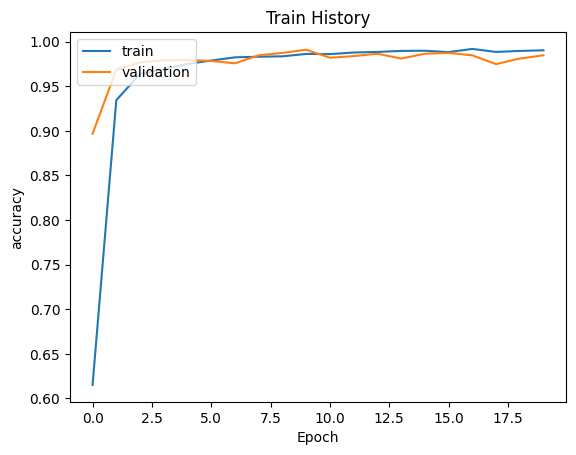

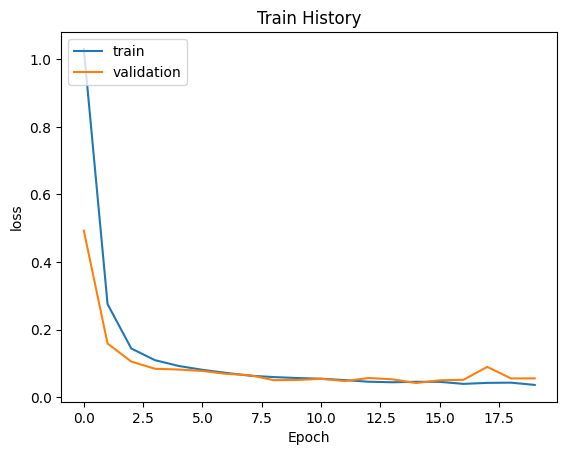

In [897]:
show_train_history(train_log, "acc", "val_acc", "accuracy")
show_train_history(train_log, "loss", "val_loss", "loss")

In [898]:
# validate your model using validation dataset
# After prediction, you need to change your result and label from one-hot encoding to categorical encoding
result = classifier.predict(val_data, workers=4, use_multiprocessing=True)
truths = np.argmax(val_labels.to_numpy(), axis=-1).tolist()
predictions = np.argmax(result, axis=-1).tolist()

35/35 [==============================] - 0s 2ms/step


In [899]:
# using sklearn classification_report function to show your validation result
print(classification_report(truths, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      0.94      0.97       181
           2       0.96      0.96      0.96       111
           3       0.99      0.98      0.98       126
           4       0.96      1.00      0.98       252

    accuracy                           0.98      1114
   macro avg       0.98      0.98      0.98      1114
weighted avg       0.99      0.98      0.98      1114



# Testing phase

### Load Data

In [900]:
# load test.csv file as dataframe
test_set: pd.DataFrame = pd.read_csv("data/test.csv", encoding="utf-8")

### Data Preprocessing

In [901]:
# Preprocessing is the same as training
test_set.drop("created_time", axis=1, inplace=True)
row_buffer: dict = dict()
for _, value in enumerate(zip(test_set["mac_hash"].values.tolist(), test_set["sniffer_loc"].values.tolist())):
    if value[0] not in row_buffer.keys():
        row_buffer[value[0]] = [0 for _ in range(14)]
    row_buffer[value[0]][int(value[1]) - 1] = 1
test_set: pd.DataFrame = pd.DataFrame(row_buffer).transpose()
test_set.columns = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14"]
test_set["mac_hash"] = test_set.index
test_set.reset_index(inplace=True)
test_set.drop("index", axis=1, inplace=True)

### Predict the result using your model

In [902]:
# X_test: feature
test_data = test_set.drop("mac_hash", axis=1)

In [903]:
# Prediction
result = classifier.predict(test_data, workers=4, use_multiprocessing=True)
predictions = np.argmax(result, axis=-1).tolist()

44/44 [==============================] - 0s 1ms/step


In [904]:
# Generate submit.csv
test_result = pd.DataFrame({"mac_hash": test_set["mac_hash"].tolist(), "label": predictions})
test_result.index.name = "Index"
test_result.to_csv("submit.csv", encoding="utf-8")